In [1]:
path = "PRIMNET/FINGER"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/taerim/PRIMNET-V2/code'

In [2]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [3]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.1', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.001, epochs=500, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('F', 'R', 'P', 'R', 'R', 'P', 'R'), marker_num=1, motor_dim=4)

In [4]:
model = PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_20.pth"))

<All keys matched successfully>

In [5]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

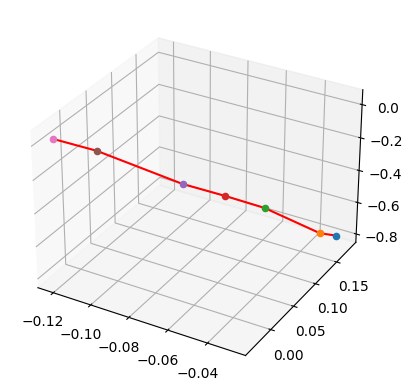

In [6]:
motor_control = torch.FloatTensor([0,0,0,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for p in ps:
    ax.scatter(p[0], p[1],p[2])

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

plt.show()